In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext blackcellmagic

## Set date range

In [3]:
# specify the date range we wish to plot
date_range = pd.date_range('01-01-2006', datetime.today().date())

## Load in data from the csv file and make sure it looks correct

In [4]:
csv_url = "https://raw.githubusercontent.com/collective-action/tech/master/actions.csv"
df = pd.read_csv(csv_url, index_col=0)
df["date"] = pd.to_datetime(df["date"])  # cast date col to datetime64
df.head()

,date,sources,actions,struggles,employment_types,description,locations,companies,workers,tags,author
0,1979-09-01,https://twitter.com/clancynewyork/status/11758...,protest,ethics,white_collar_workers,"IBM workers formed an organization, IBM: Speak...",worldwide,ibm,None,international_solidarity,nataliyaned
1,1986-09-16,https://www.nytimes.com/1986/09/16/science/sof...,open_letter,ethics,white_collar_workers,Fourteen employees at AT&T sign a letter warni...,usa,at&t,14,None,nataliyaned
2,1986-09-16,https://www.nytimes.com/1986/09/16/science/sof...,open_letter,ethics,white_collar_workers,"A group of computer professionals, led by Comp...",usa,None,30,None,nataliyaned
3,1994-01-24,https://www.nytimes.com/1994/06/12/magazine/ba...,open_letter,ethics,white_collar_workers,Computer Professionals for Social Responsibili...,online,None,50000,None,nataliyaned
4,1998-11-23,http://www.cnn.com/tech/computing/9811/23/mste...,legal_action,"unfair_labor_practices, pay_and_benefits",contract_workers,A law firm representing 10 current and former ...,usa,microsoft,10,None,organizejs


In [5]:
len(df)

251

## One-hot encode "struggles", "employment_types", "actions", "companies"


In [6]:
def ohe(field):
    return (
        df[field].str.replace(" ", "").str.get_dummies(sep=",").add_prefix(f"{field}_")
    )

In [7]:
ohe_df = (
    df.join(ohe("struggles"))
    .join(ohe("actions"))
    .join(ohe("companies"))
    .join(ohe("employment_types"))
    .drop(["struggles", "actions", "companies", "employment_types"], axis=1)
)

In [8]:
ohe_df.head()

,date,sources,description,locations,workers,tags,author,struggles_discrimination,struggles_ethics,struggles_job_security,...,companies_wholefoods,companies_wikipedia,companies_yahoo,companies_youtube,employment_types_blue_collar_workers,employment_types_contract_workers,employment_types_gig_workers,employment_types_in_house_workers,employment_types_na,employment_types_white_collar_workers
0,1979-09-01,https://twitter.com/clancynewyork/status/11758...,"IBM workers formed an organization, IBM: Speak...",worldwide,None,international_solidarity,nataliyaned,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1986-09-16,https://www.nytimes.com/1986/09/16/science/sof...,Fourteen employees at AT&T sign a letter warni...,usa,14,None,nataliyaned,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1986-09-16,https://www.nytimes.com/1986/09/16/science/sof...,"A group of computer professionals, led by Comp...",usa,30,None,nataliyaned,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1994-01-24,https://www.nytimes.com/1994/06/12/magazine/ba...,Computer Professionals for Social Responsibili...,online,50000,None,nataliyaned,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1998-11-23,http://www.cnn.com/tech/computing/9811/23/mste...,A law firm representing 10 current and former ...,usa,10,None,organizejs,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Defining worker priviledge vs precarity

In [9]:
ohe_df["is_priviledged"] = [
    True if x > 0 else False
    for x in ohe_df[
        ["employment_types_white_collar_workers"]
    ].sum(axis=1)
]

## Visualize total actions per month over past 3 years

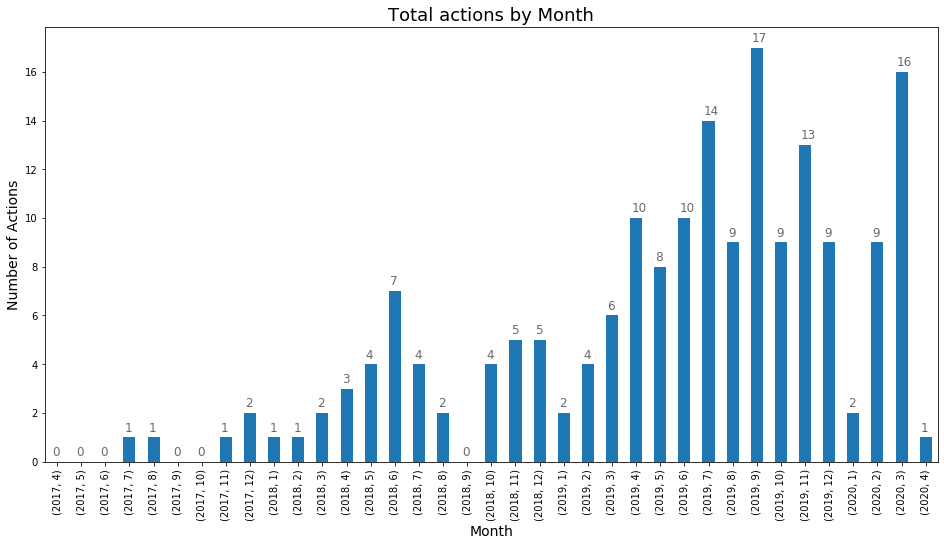

In [10]:
# fill dataframe with zeros for dates where no actions happened
sparse_df = df.loc[:, "date"].value_counts()

# set date range for month graph
today = datetime.today().date()
three_yrs_ago = f"{today.month}-{today.day}-{today.year-3}"
date_range_month = pd.date_range(three_yrs_ago, datetime.today().date())

# fill dataframe with zeros for dates where no actions happened
sparse_df = (
    df.loc[:, "date"]
    .value_counts()
    .reindex(date_range_month, fill_value=0)
    .to_frame(name="count")
)

# aggregate our dataframe by month
yearly_monthly_df = sparse_df.groupby([(sparse_df.index.year),(sparse_df.index.month)]).sum()

# plot the bar graph with annotation
ax = yearly_monthly_df.plot(kind="bar", figsize=(16, 8), legend=False)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Total actions by Month", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() + 0.05,
        i.get_height() + 0.25,
        i.get_height(),
        fontsize=12,
        color="dimgrey",
    )

## Visualize total actions per year

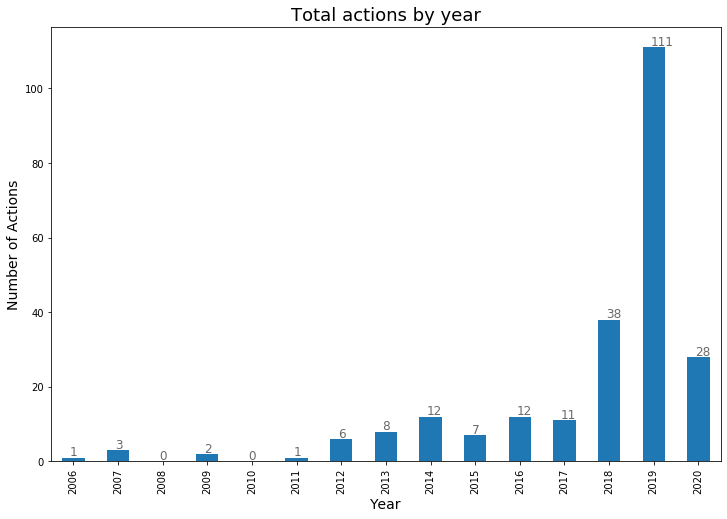

In [11]:
# fill dataframe with zeros for dates where no actions happened
sparse_df = df.loc[:, "date"].value_counts()

# fill dataframe with zeros for dates where no actions happened
sparse_df = (
    df.loc[:, "date"]
    .value_counts()
    .reindex(date_range, fill_value=0)
    .to_frame(name="count")
)

# aggregate our dataframe by year
yearly_df = sparse_df.groupby([sparse_df.index.year.rename("year")]).agg({"sum"})

# plot the bar graph with annotation
ax = yearly_df.plot(kind="bar", figsize=(12, 8), legend=False)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Total actions by year", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() + 0.175,
        i.get_height() + 0.5,
        i.get_height(),
        fontsize=12,
        color="dimgrey",
    )

In [12]:
def get_yearly_count(cond):
    # fill dataframe with zeros for dates where no actions happened
    sparse_ohe_df = (
        ohe_df[ohe_df["is_priviledged"] == cond].loc[:, "date"].value_counts()
    )

    # fill dataframe with zeros for dates where no actions happened
    sparse_ohe_df = (
        ohe_df[ohe_df["is_priviledged"] == cond]
        .loc[:, "date"]
        .value_counts()
        .reindex(date_range, fill_value=0)
        .to_frame(name="count")
    )

    # aggregate our dataframe by year
    yearly_df = sparse_ohe_df.groupby([sparse_ohe_df.index.year.rename("year")]).agg(
        {"sum"}
    )
    yearly_df.columns = yearly_df.columns.get_level_values(0)
    return yearly_df

In [13]:
priviledged_vs_precarious_yearly_df = get_yearly_count(True).join(
    get_yearly_count(False),
    lsuffix="_of_priviledged_workers",
    rsuffix="_of_precarious_workers",
)

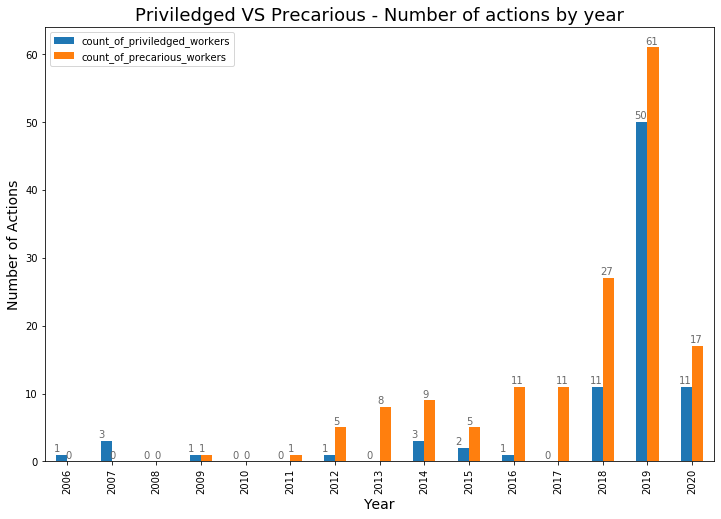

In [14]:
ax = priviledged_vs_precarious_yearly_df.plot(kind="bar", figsize=(12, 8))
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Priviledged VS Precarious - Number of actions by year", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() - 0.05,
        i.get_height() + 0.5,
        i.get_height(),
        fontsize=10,
        color="dimgrey",
    )

## Visualize total distribution of struggle

In [15]:
def get_struggles(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("struggles_*")).sum()


struggles = pd.DataFrame(get_struggles(True)).join(
    pd.DataFrame(get_struggles(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)

Text(0.5, 1.0, 'Actions by kind of struggle')

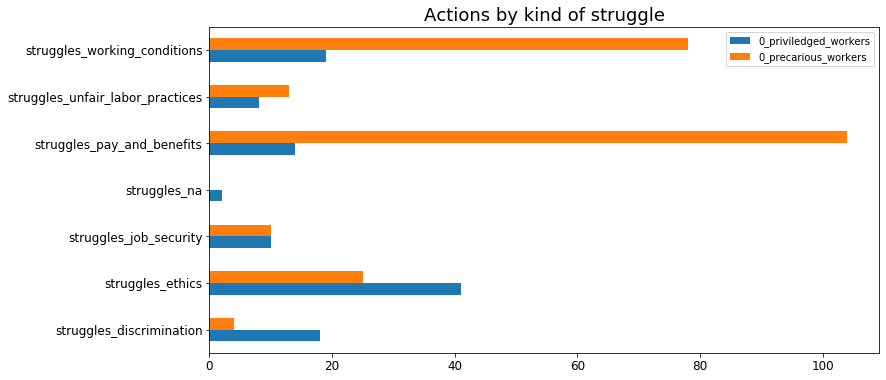

In [16]:
ax = struggles.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_ylabel(None)
ax.set_title("Actions by kind of struggle", fontsize=18)

## Visualize distribution of struggles over the years

In [17]:
def get_actions(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("actions_*")).sum()


actions = pd.DataFrame(get_actions(True)).join(
    pd.DataFrame(get_actions(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)

Text(0.5, 1.0, 'Actions by kind of struggle')

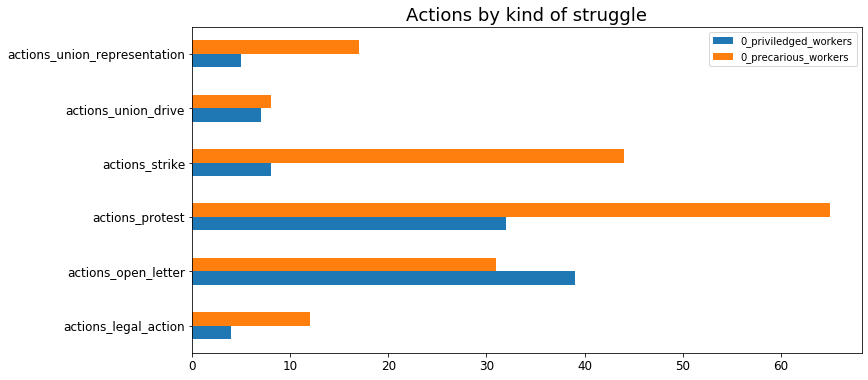

In [18]:
ax = actions.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_ylabel(None)
ax.set_title("Actions by kind of struggle", fontsize=18)

## Analyzing employee activism by company

In [19]:
top_10_companies_df = ohe_df.filter(regex=("companies_*")).sum().sort_values()[-10:]

Text(0.5, 1.0, 'Collective action by top companies')

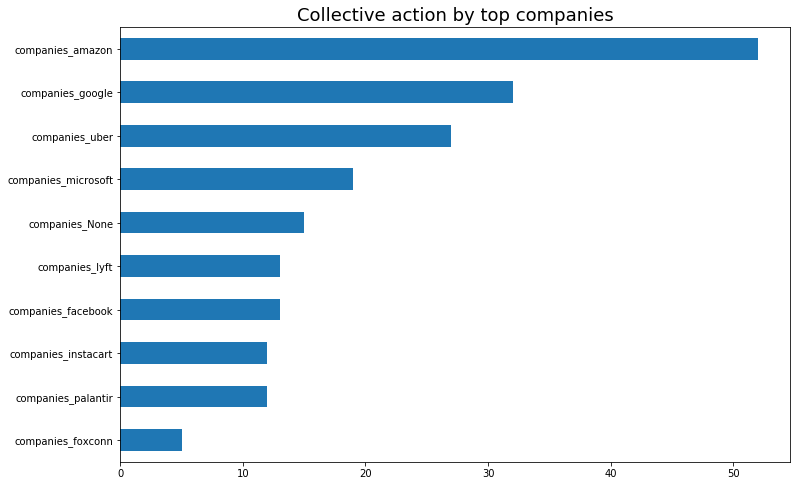

In [20]:
ax = top_10_companies_df.plot(kind="barh", figsize=(12, 8))
ax.set_title("Collective action by top companies", fontsize=18)

In [21]:
def get_top_companies(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("companies_*")).sum()


top_companies = pd.DataFrame(get_top_companies(True)).join(
    pd.DataFrame(get_top_companies(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)
top_companies = (
    top_companies.assign(tmp=top_companies.sum(axis=1))
    .sort_values(by="tmp")[-10:]
    .drop("tmp", 1)
)

Text(0.5, 1.0, 'Collective action by top companies')

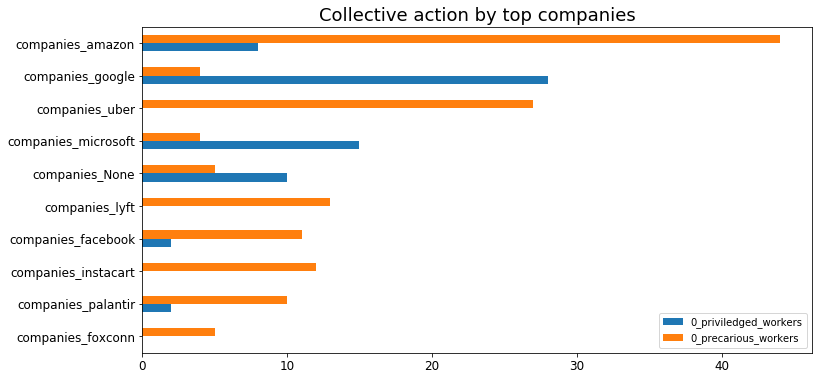

In [22]:
ax = top_companies.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_title("Collective action by top companies", fontsize=18)

## Using word clouds

Define some helper funcs

In [23]:
# color generator function
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(230,100%%,%d%%)" % np.random.randint(30,60))

# helper function to get words from df columns
def get_text(col):
    return df[col].str.cat(sep=" ").replace(",", "").replace("None", "")

# helper func to pot word cloud
def plot_cloud(text, figsize=(18,12)):
    wc_params = {
        "background_color": "white", 
        "width": figsize[0]*100, 
        "height": figsize[1]*100, 
        "collocations": False
    }
    wc = WordCloud(**wc_params).generate(text)
    wc.recolor(color_func = grey_color_func)
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

Visualize descriptions

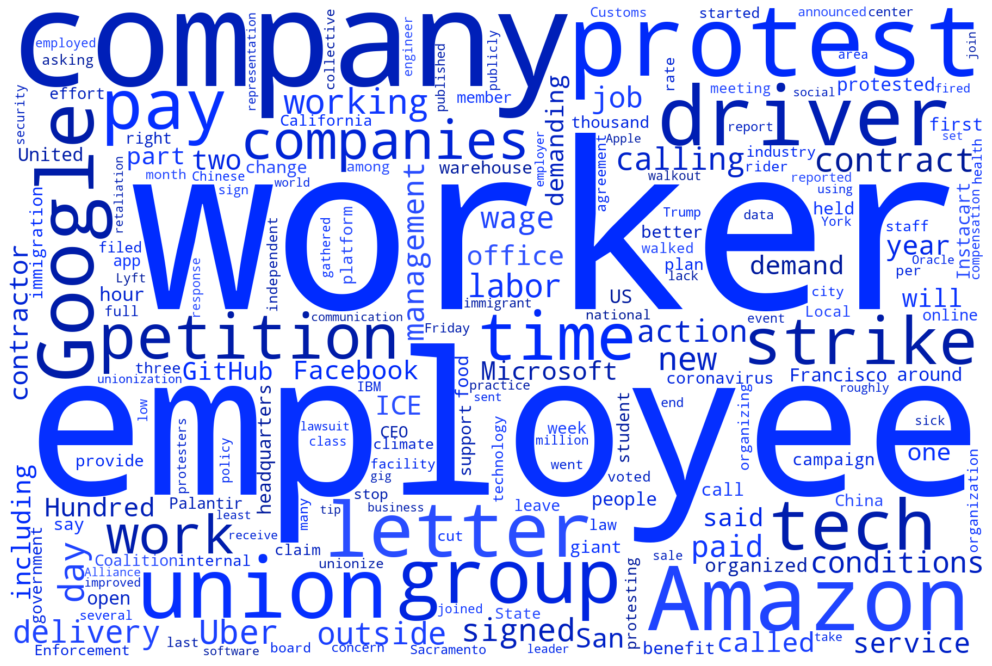

In [24]:
text = get_text('description')
plot_cloud(text)

visualize tags

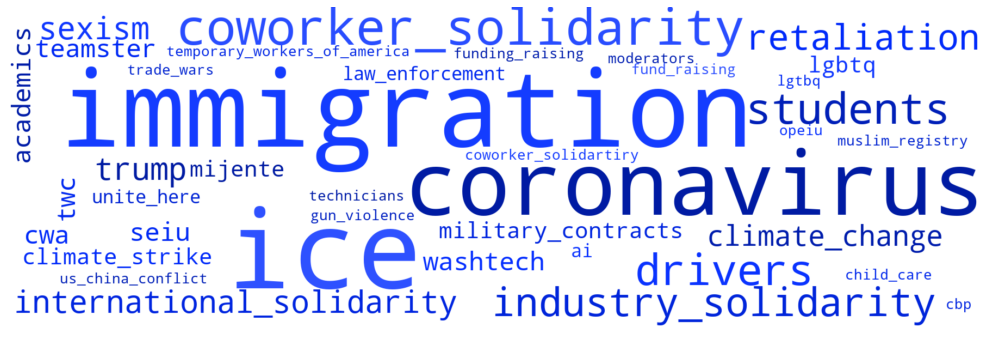

In [25]:
text = get_text('tags')
plot_cloud(text, figsize=(18, 6))

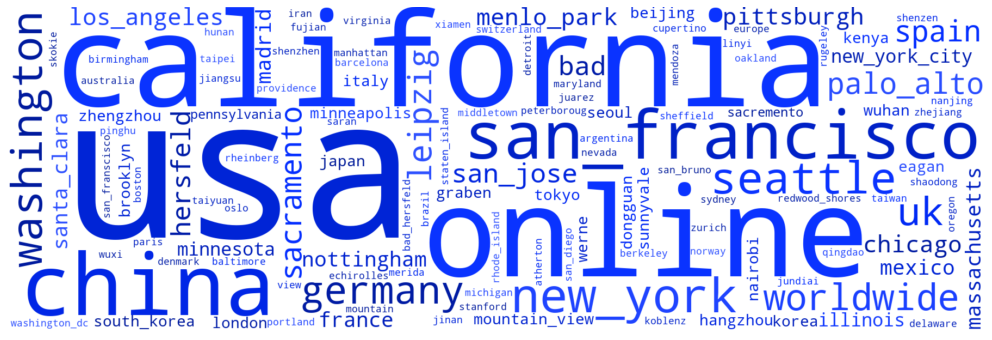

In [26]:
text = get_text('locations')
plot_cloud(text, figsize=(18, 6))